## A Systematic Prediction of Clothing Recommendation for Women Aged 20-35 using Machine Learning.

**Background**

The topic of predicting product recommendations using machine learning revolves around leveraging advanced algorithms and data analysis techniques to forecast and suggest products or services that are likely to be of interest to individual customers. By analyzing historical purchase data, user preferences, and other relevant information, machine learning models can be trained to make personalized recommendations, enhancing the customer experience and driving business growth. It is important to investigate the various strategies introduced to achieve a more efficient way of predicting product recommendation in order to better understand which techniques are to be used for the best possible outcome. The primary aim of forecasting is to better understand the patterns that impacts markets and consumer needs. This study utilizes the state-of-the-art methods used to predict product recommendation in the fashion industry that could be implemented in the real world. The methods implemented to forecast, the models and algorithms used within the methods, the datasets used, and also the trade-offs for each system and model used are described in this analysis. In particular, this analysis will further explore Machine Learning models that are widely applied to support the forecasting efforts carried out in the fashion industry. The scope of this analysis is for customers within the age of 20 to 35.

**Date source**: www.kaggle.com/datasets/surajjha101/myntra-reviews-on-women-dresses-comprehensive

**The Dataset**

1) S.no: Number of data sample<br>
2) Age: Age of the customer<br>
3) Division name: Division of the cloth customer has bought<br>
4) Department name: Department of the cloth<br>
5) Class name: Class of the cloth in particular<br>
6) Clothing id: Clothing ID (Unique to a type of product)<br>
7) Title: Title customers write on their feedback/review text<br>
8) Review text: Customer's review text<br>
9) Alike feedback count: Number of other customers who agree with the given feedback (as their experience is quite the same)<br>
10) Rating: Rating or stars they've given to the product<br>
11) Recommend_index: Whether they'll recommend someone to buy the product or not(0: NO, 1: YES)


In [1]:
%%capture
pip install textacy

In [2]:
%%capture
pip install dmba

In [3]:
# Save the dataset in a folder on Google Drive and mount the drive contents on Google Colab
from google.colab import drive

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import f_oneway, chi2_contingency
import re
import html
import textacy.preprocessing as tprep
from dmba import classificationSummary
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Display settings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# Set a random seed for reproducibility
np.random.seed(42)

# Set matplotlib to display plots inline
%matplotlib inline

# Mount the Google Drive contents
drive.mount('/content/drive/')

Colab environment detected.
Mounted at /content/drive/


In [4]:
# Some helper functions for visualising the dataset

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height()
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [5]:
# reading the dataset from the drive
df = pd.read_csv("/content/drive/MyDrive/fashion prediction/Women Dresses Reviews Dataset.csv")


# Limiting this analysis to focus on customers within the defined age bracket (20 - 35)

df = df[(df["age"] >= 20) & (df["age"] <= 35)]

**Preliminary Exploration of the Dataset**

In [6]:
df.head()

,s.no,age,division_name,department_name,class_name,clothing_id,title,review_text,alike_feedback_count,rating,recommend_index
7,7,34,General,Tops,Knits,868,Unique and wonderful,The sweater is comfortable and a good weight. ...,2,5,1
10,10,32,General,Tops,Knits,872,Great fit,I have been searching around for new and uniqu...,0,5,1
13,13,23,General,Bottoms,Skirts,1020,"Cute, but not flattering on","I really loved this skirt on the model, but it...",0,2,0
15,15,31,General,Dresses,Dresses,1086,Not for my curves,"5'7"", 34c, 28 jeans, size 4 dress. fell in lov...",5,3,0
19,19,35,General Petite,Tops,Blouses,835,NaN,"Beautiful top, i love the peplum. the color is...",2,3,1


>*The table above shows the first five records in the dataset.*

In [7]:
df[["age", "alike_feedback_count", "rating"]].describe().T

,count,mean,std,min,25%,50%,75%,max
age,6932.0,29.950087,4.071265,20.0,27.0,31.0,33.0,35.0
alike_feedback_count,6932.0,2.210040,5.509428,0.0,0.0,0.0,2.0,122.0
rating,6932.0,4.163445,1.124215,1.0,4.0,5.0,5.0,5.0


>*The table above shows the summary statistics of the numerical variables in the dataset. This includes the count, mean, standard deviation, 25th percentile, 50th percentile, 75th percentile, and the maximum value.*

>*age has **mean** (29.95), **median** (31.0) and **standard deviation** (4.07)*

>*alike feedback count has **mean** (2.21), **median** (0.0) and **standard deviation** (5.51)*

>*rating has **mean** (4.16), **median** (5.0) and **standard deviation** (1.12)*

In [8]:
len(df)

6932

In [9]:
df.shape

(6932, 11)

>*The dataset contains 6,932 records and 11 columns.*

In [10]:
df[df.dtypes[df.dtypes == "object"].index].shape

(6932, 5)

>*The dataset contains 5 categorical features*

In [11]:
df[df.dtypes[df.dtypes == "int64"].index].shape

(6932, 6)

>*The dataset contains 6 numeric features*

In [12]:
df.isna().sum()

s.no                       0
age                        0
division_name              4
department_name            4
class_name                 4
clothing_id                0
title                   1162
review_text              296
alike_feedback_count       0
rating                     0
recommend_index            0
dtype: int64

>*The features with missing values in the dataset are division name, department name, class name, title and review text. The missing values in these features will be treated using appropriate techniques.*

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6932 entries, 7 to 23483
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   s.no                  6932 non-null   int64 
 1   age                   6932 non-null   int64 
 2   division_name         6928 non-null   object
 3   department_name       6928 non-null   object
 4   class_name            6928 non-null   object
 5   clothing_id           6932 non-null   int64 
 6   title                 5770 non-null   object
 7   review_text           6636 non-null   object
 8   alike_feedback_count  6932 non-null   int64 
 9   rating                6932 non-null   int64 
 10  recommend_index       6932 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 649.9+ KB


>*The info method shows the range index(the number of entries in the data), the column names, the number of non missing values and the variable type. The data contains only integer and object values.*

**Exploratory Data Analysis and Visualisation**

>*The popular saying "a picture is worth a thousand words" refers to the ability to condense diffused verbal information into a compact and quickly understood graphical image. In the case of numbers, data visualization and numerical summarization provide both a powerful tool to explore data and an effective way to present results. Visualization techniques are primarily used in the preprocessing portion of the data mining process. Visualisation supports data cleaning by finding incorrect values, missing values, duplicate rows, columns with all the same value, and the like. Visualisation techniques are also useful for variable derivation and selection: they can help determine which variables to include in the analysis and which might be redundant. They can also help with determining appropriate bin sizes, should binning of numerical variables be needed. They can also play a role in combining categories as part of the data reduction process. In this study, some of the visuals used include barcharts and histogram.*

**Heatmap of Missing Values in the Dataset. Grey Denotes Missing Value**

>*In a missing value heatmap, rows correspond to records and columns to variables. Binary coding of the original dataset is done where 1 denotes a missing value and  otherwise. This new binary table is then coloured such that only missing value cells (with value 1) are coloured.*

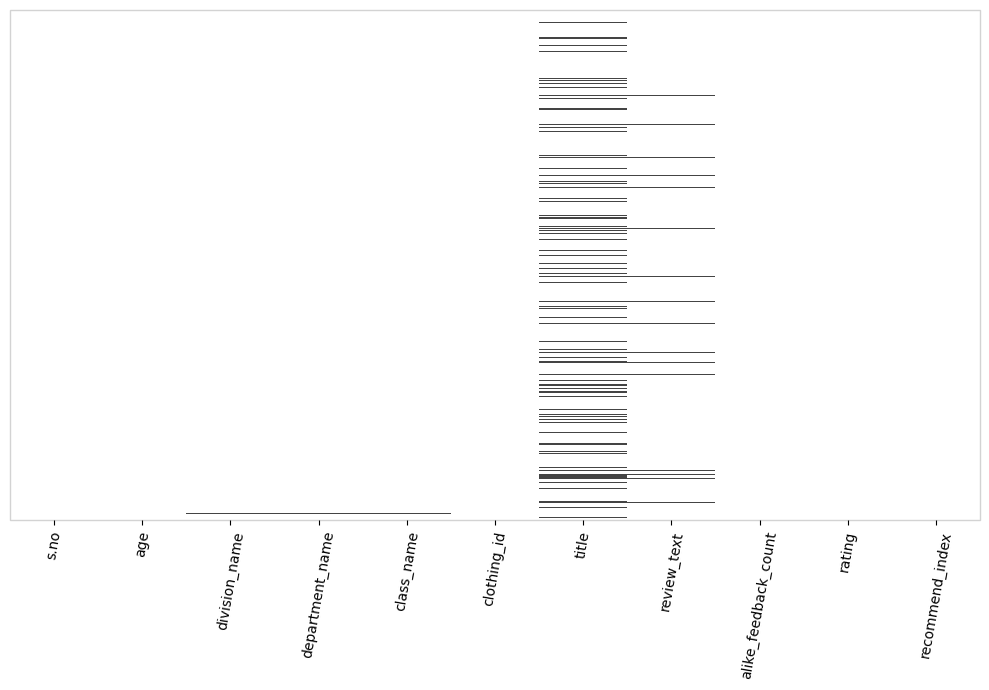

In [14]:
# Given a dataframe df create a copy of the array that is 0 if a field contains a value
# and 1 for NaN
naInfo = np.zeros(df.shape)
naInfo[df.isna().values] = 1
naInfo = pd.DataFrame(naInfo, columns=df.columns)

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax = sns.heatmap(naInfo, vmin=0, vmax=1, cmap=["white", "#444444"], cbar=False, ax=ax)
ax.set_yticks([])

rect = plt.Rectangle((0, 0), naInfo.shape[1], naInfo.shape[0], linewidth=1,
                     edgecolor='lightgrey',facecolor='none')
rect = ax.add_patch(rect)
rect.set_clip_on(False)

plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

>*The heatmap above shows that title is the variable containing the highest number of missing values. One of the possible approaches to address this might be to eliminate all the records containing missing values for review text. This method will be relevant if a significant number of records are retained for modelling.*

**Univariate Analysis on division name, department name and rating**

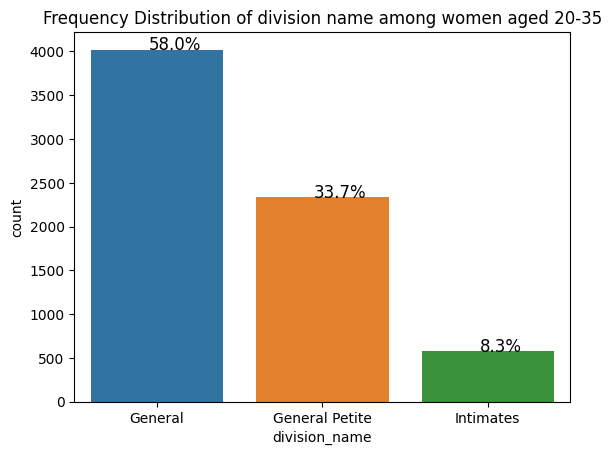

In [15]:
# checking the division name
ax = sns.countplot(x="division_name", data = df, order = df["division_name"].value_counts().index)
ax.set(title='Frequency Distribution of division name among women aged 20-35')
without_hue(ax, df["division_name"])

>*The chart above shows that women within the age bracket of 18-99 buy more of general clothes and they purchase less of intimates clothes.*

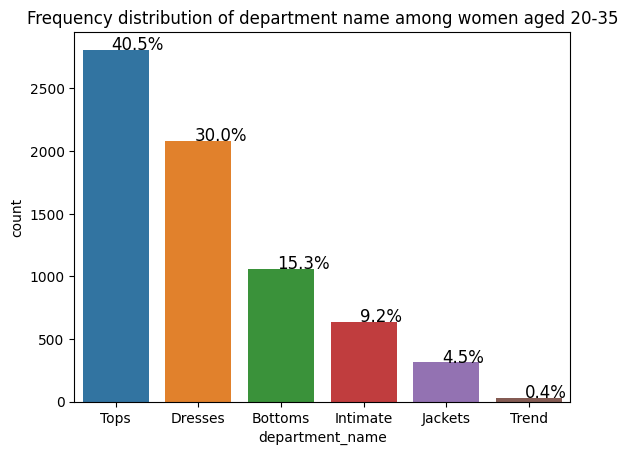

In [16]:
# checking department name
ax = sns.countplot(x="department_name", data = df, order = df["department_name"].value_counts().index)
ax.set(title='Frequency distribution of department name among women aged 20-35')
without_hue(ax, df["department_name"])

>*The chart above shows that 40.5% of women within the age bracket of 20-35 purchase tops, 30.0% purchase dresses, 15.3% purchase bottoms, 9.2% purchase intimate clothes, 4.5% purchase jackets and 0.4% purchase trendy clothes. The chart shows the preference of these consumers as regards what appeals to their fashion sense.*

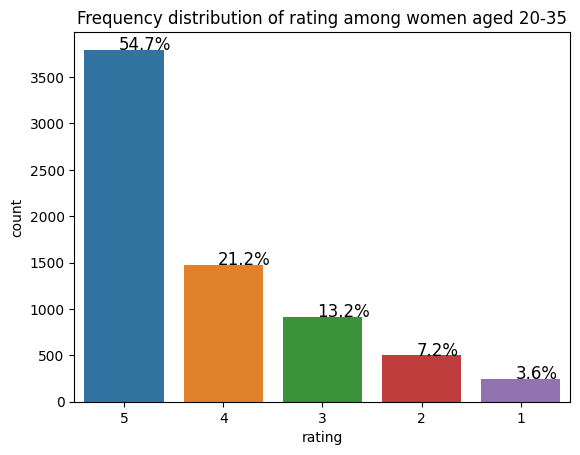

In [17]:
# checking rating
ax = sns.countplot(x="rating", data = df, order = df["rating"].value_counts().index)
ax.set(title='Frequency distribution of rating among women aged 20-35')
without_hue(ax, df["rating"])

>*The chart above shows that 54.7% of fashion products are given a rating of 5, 21.2% are given a rating of 4, 13.2% are given a rating of 3, 7.2% are given a rating of 2 and 3.6% are given a rating of 1. This means most products are purchased by women within the age bracket are of a good quality.*

**Bivariate Analysis on division name, department name and rating**

>*In this section, division name, department name and rating will also be explored with respect to the target feature (recommend_index). The underlying idea is to quantify the relationships between each independent variable and dependent variables at certain levels of values for each variable, this can help in identifying a subset of the variables that are more important and also know about the important levels of particular features values.*

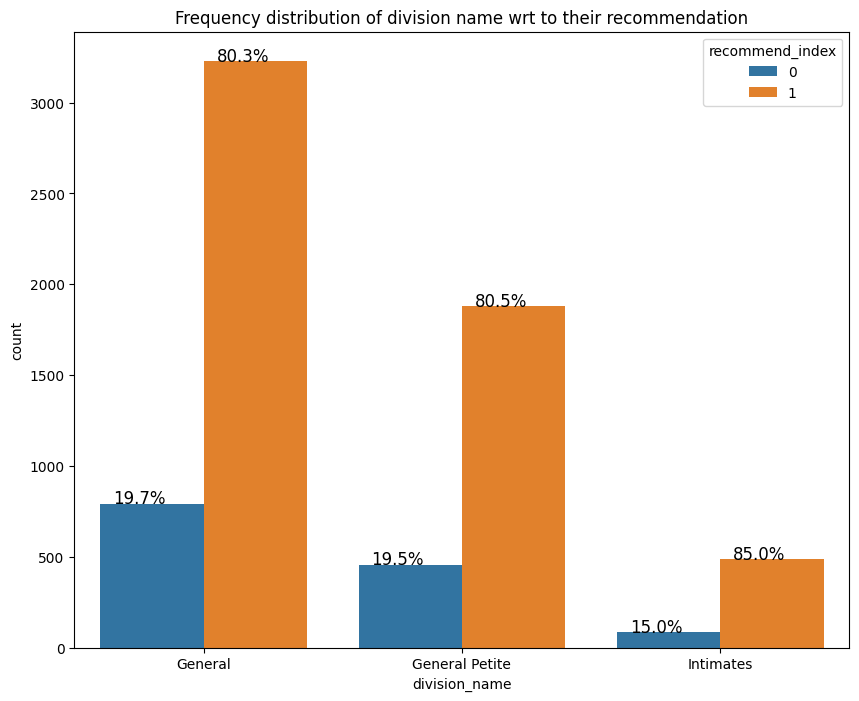

In [18]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x = 'division_name', data = df,hue='recommend_index', order = df['division_name'].value_counts().index)
ax.set(title = "Frequency distribution of division name wrt to their recommendation")
with_hue(ax, df['division_name'], df['division_name'].nunique(), df['recommend_index'].nunique())

>*The chart above shows that most of the fashion products not recommended belong to the general division and the disparity between the recommendations for each of the division name is very high.*

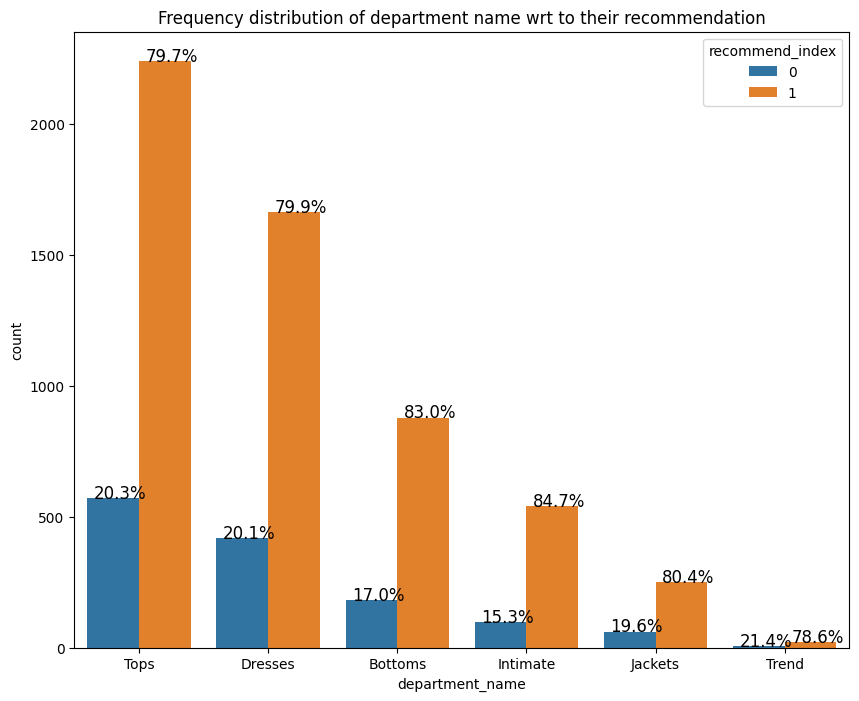

In [19]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x = 'department_name', data = df,hue='recommend_index', order = df['department_name'].value_counts().index)
ax.set(title = "Frequency distribution of department name wrt to their recommendation")
with_hue(ax, df['department_name'], df['department_name'].nunique(), df['recommend_index'].nunique())

>*The chart above shows the frequency distribution of each department based on their recommendation. The tops departments which have the highest frequency has 79.7% of recommendation and 20.3% no recommendation, Dresses have 79.9% recommendation and 20.1% no recommendation, bottoms have 83.0% recommendations and 17.0% no recommendation, Intimates have 84.7% recommendation and 15.3% no recommendation, Jackets have 80.4% recommendation and 19.6% no recommendation while trendy wears have 78.6% recommendation and 21.4% no recommendation.*

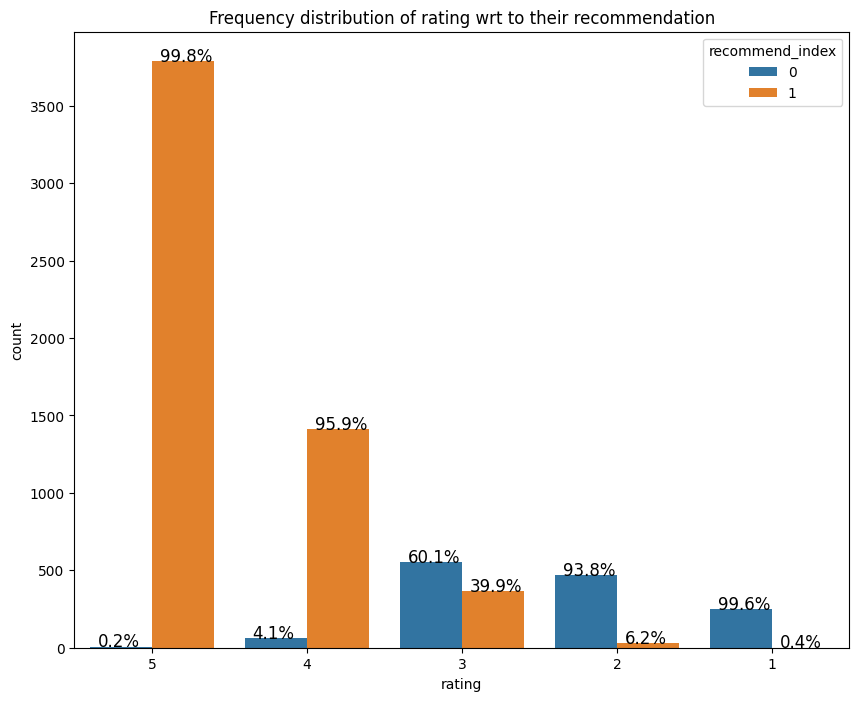

In [20]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x = 'rating', data = df,hue='recommend_index', order = df['rating'].value_counts().index)
ax.set(title = "Frequency distribution of rating wrt to their recommendation")
with_hue(ax, df['rating'], df['rating'].nunique(), df['recommend_index'].nunique())

>*The chart above clearly shows most products with a rating of 5 are recommended while most of the products with a rating of 1 are not recommended.*

**Treating Missing Values**

**Treating missing values by removing all records that contain them**

>*The data contain missing values, with title being the column with the highest number of missing values. An approach to dealing with a data with missing values is by removing all records that contain them. This method will be applied in this scenario.*

In [21]:
df_a = df.copy()
df_a = df_a.dropna(axis = 0, how = "any")
df_a.shape

(5765, 11)

>*Using this method, the 16.83% of the records were dropped. The rows have now been reduced to 5,765 which is sufficient for the modelling.*

**Feature Selection**

>*The feature selection method employed for this study is the chi-square test and the ANOVA test.The ANOVA test method is used for statistical measurement of relationship strength between the categorical target variable (recommend_index) and the continuous predictor (age and alike_feedback_count) while the chi-square test is used to test the relationship between the categorical target variable (recommend_index) and the categorical predictors (division_name, department_name, and class name). Title and Review text which are critical predictors will be combined, cleaned and tokenized before the modelling process.*

**Statistical Feature Selection (Categorical Vs Continuous) using ANOVA test**

Analysis of variance (ANOVA) is performed to check if there is any relationship between the given continuous and categorical variable.
- Assumption(H0): There is NO relationship between the given variables (i.e The average (mean) values of the numeric predictor variable is same for all the groups in the categorical target variable).
- ANOVA test result: Probability of H0 being true.

In [22]:
# Defining a function to find the statistical relationship with all the categorical variables
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)

        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])

    return(SelectedPredictors)

In [23]:
# Calling the function to check which continuous variables are correlated with target
ContinuousVariables=["age", "alike_feedback_count"]
FunctionAnova(inpData=df_a, TargetVariable="recommend_index", ContinuousPredictorList=ContinuousVariables)

##### ANOVA Results ##### 

age is correlated with recommend_index | P-Value: 0.0023740022997479375
alike_feedback_count is correlated with recommend_index | P-Value: 1.9976410807102355e-05


['age', 'alike_feedback_count']

>*The results of ANOVA confirms that age and alike_feedback_count are correlated with the target class. These predictors will also be used for modelling.*

**Statistical Feature Selection (Categorical Vs Categorical) using Chi-Square Test**

Chi-Square test is conducted to check the correlation between two categorical variables:
- Assumption(H0): The two columns are NOT related to each other.
- Result of Chi-Sq Test: The probability of H0 being true.

In [24]:
# convert rating to a category data type
df_a["rating"] = df_a["rating"].astype('category')

In [25]:
# Writing a function to find the correlation of all categorical variables with the Target variable
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)

        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])

    return(SelectedPredictors)

In [26]:
CategoricalVariables=["division_name", "department_name", "class_name", "rating"]

# Calling the function
FunctionChisq(inpData=df_a,
              TargetVariable="recommend_index",
              CategoricalVariablesList= CategoricalVariables)

division_name is NOT correlated with recommend_index | P-Value: 0.17321721410707838
department_name is correlated with recommend_index | P-Value: 0.04608240383650771
class_name is NOT correlated with recommend_index | P-Value: 0.2901279734760079
rating is correlated with recommend_index | P-Value: 0.0


['department_name', 'rating']

>*Based on the results of the Chi-Square test, not all the categorical features are correlated with the target class. Hence, only department_name and rating will be used for modelling.*

**Prepating Textual Data for Modelling**

Technically, any text document is just a sequence of characters. To build models on the content, there is a need to transform a text into a sequence of words or, more generally, meaningful sequences of characters called *tokens*. But that alone is not sufficient. Think of the word sequence, *New York*, which shoukd be treated as a single named entity. Correctly identifying such words sequences as compound structures requires sophisticated linguistic processing.

Data preparation or data preprocessing in general involves not only transformation of data into a form that can serve as the basis for analysis but also the removal of disturbing noise. When working with text, noise comes in different flavours. The raw data may include HTML tags or special characters that should be removed in most cases. But frequent words carrying little meaning, the so-called *stop words*, introduce noise to machine learning and data analysis because they make it harder to detect patterns.

*Tokenization*, which will also be applied in the cleaning process splits a document into a list of separate tokens like words and punctuation characters. *Part-of-speech (POS) tagging* is the process of determining the word class, whether it's a noun, a verb, an article, etc. *Lemmatization* maps inflected words to their uninflected root, the lemma (e.g., "are" -> "be"). The target of *named-entity recognition* is the identification of references to people, organizations, locations, etc., in the text.

**Identifying Noise with Regular Expressions**

The following function helps to identify noise in texttual data. Noise in this context means everything that is not plain text and may therefore disturb further analysis. The function uses a regular expression to search for a number of suspicious characters and returns their share of all characters as a score for impurity. Very short texts (less than min_len characters) are ignored because here a special character would lead to a significant impurity and distort the result.

In [27]:
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len = 10):
  """return the share of suspicious characters in a text"""
  if text == None or len(text) < min_len:
    return 0
  else:
    return len(RE_SUSPICIOUS.findall(text))/len(text)

In [28]:
df_a['impurity'] = df_a["review_text"].apply(impurity, min_len = 10)

In [29]:
# get the top 3 records
df_a[["review_text", "impurity"]].sort_values(by = "impurity", ascending = False).head()

,review_text,impurity
23172,Love the look and quality of this jacket. i&am...,0.032967
3343,This is the rare metallic that doesn&#39;t itc...,0.027682
3297,Love this skirt - it looks precisely as the ph...,0.027523
18728,Love this top!! fits perfectly & it's lovely,0.022727
10307,Just bought this top in an xs and i can&amp;#3...,0.021583


>*The table above shows the most "impure" records. Obviously, there are special characters like !, # and & included. Also, we have punctuation marks like . and ;*

**Removing Noise with Regular Expressions**

The approach employed to data cleaning for the review_text variable consists of defining a set of regular expressions and identifying problematic patterns and corresponding substitution rules. The blueprint function first substitutes all HTML escapes(e.g.,& amp;) by their plain-text representation and then replaces certain patterns by spaces. Finally, sequences of whitespaces are pruned:

In [30]:
# combining the title and review columns to create a single text value and apply the text cleaning blueprint
df_a['review_text'] = df_a['title'] + ' ' + df_a['review_text']

In [31]:
def clean(text):
    # Combine multiple regex patterns into a single pattern
    pattern = r'<[^<>]*>|\[([^\[\]]*)\]\([^\(\)]*\]|\[[^\[\]]*\]|(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)|(?:^|\s)[\-=\+]{2,}(?:\s|$)|[^\w\s]|\s+'

    # Perform regex substitution in a single pass
    text = re.sub(pattern, ' ', text)

    # Remove whitespace and convert to lowercase
    text = text.strip().lower()

    # Convert html escapes like &amp; to characters
    text = html.unescape(text)

    return text

In [32]:
df_a['clean_text'] = df_a['review_text'].map(clean)
df_a['impurity_clean']   = df_a['clean_text'].apply(impurity, min_len=20)

In [33]:
df_a[['clean_text', 'impurity_clean']].sort_values(by='impurity_clean', ascending=False) \
                              .sample(10)

,clean_text,impurity_clean
2878,no issue with fit lovely dress in bright teal ...,0.0
8985,maeve has failed on this maeve is one of my ...,0.0
18867,a staple piece in your closest like others ...,0.0
1385,elevated basic i bought this tank in gold and...,0.0
9278,very cute dress for a different body type th...,0.0
14417,worth it for me i rarely write reviews on here...,0.0
18654,very chic this dress looks very good on me i...,0.0
10204,perfect tank to be dressed up or down great ta...,0.0
11636,a size 2 too big i am usually a size 2 in tops...,0.0
5022,keeper love the muted orange color and the de...,0.0


>*This looks prettty good as the impurity value is now zero.*

The function below is used to standardize fancy hypens and quotes and it removes accents with the help of textacy

In [34]:
def normalize(text):
        text = tprep.normalize.hyphenated_words(text)
        text = tprep.normalize.quotation_marks(text)
        text = tprep.normalize.unicode(text)
        text = tprep.remove.accents(text)
        return text

In [35]:
df_a['clean_text_new'] = df_a['clean_text'].map(normalize)

In [36]:
df_a['clean_text_new'].sample(10)

19035    love how it looks but doesn t hold up i love t...
11458    not for wide rib cage this dress is the perfec...
7815     beautiful dress this is a beautiful dress  fit...
2441     colors look nothing like online photos   when ...
21070    nice color  love the snap buttons this skirt i...
8576     flattering i love this dress i have it in the ...
16125    can t wear a bra and it is see through this is...
19894    super cute light weight beach cover up i bough...
13258    massive  i get that it s a swing tank  and it ...
20670    strange fit i put a lot of hopes on this pullo...
Name: clean_text_new, dtype: object

>*We can see from the preceding summary of the text feature that the cleaning process has removed a lot of special characters; the statements that form the customer review are retained. This is useful information that the model can use to understand the recommendation and will have impact on its categorization.*

**Dropping all irrelevant columns**

In [37]:
df_a = df_a.drop(columns = {"s.no", "clothing_id", "title", "review_text", "impurity", "clean_text", "impurity_clean", "division_name", "class_name"})

df_a = df_a.rename(columns = {"clean_text_new": "review_text"})

**One-hot encoding categorical features**

In [38]:
cat_cols = ['department_name',  'rating'] # a list of categorical predictor features

df_a = pd.get_dummies(df_a, drop_first = True, columns = cat_cols)

df_a.columns = df_a.columns.str.lower()

**Separating the data into dependent and independent features for SVM modelling**

In [39]:
X = df_a["review_text"] # Independent variable
y = df_a["recommend_index"] # Dependent(target) Variable

**Train-Test Split**

>*The data is splitted so that the next step of vectorization is performed using only the training dataset. An 80-20 split of the data is created with a confirmation that the zero and one of the target class show a similar distribution across the two splits by specifying the target variable, recommend_index, as the stratify argument:*

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print('size of training data ', x_train.shape[0])
print('size of test data ', x_test.shape[0])

size of training data  4612
size of test data  1153


**Training the Machine Learning Model**

The next step in creating the text classification blueprint is to train a supervised machine learning using two suitable algorithm: Support Vector Machine (SVM) and Random Forest (RF). For the first set of models SVM and RF will be trained only on the text feature while for the second set of models SVM and RF will be trained using the rating and department_name features. The performance of each of these models will then be compared considering the features used for modelling.


***How SVM works***

SVM is one of the popular algorithms used when working with text classification. Consider a set of points in the X-Y plane with each point belonging to one of two classes: cross or circle. The SVM works by choosing a line that separates the two classes. Of course, there could be several such lines (shown by the dotted options in the figure below), and the algorithm chooses the line that provides the maximum separation between the closest cross and circle points (identified with a box aroud them). These closest cross and circle points are referred to as *support vectors*. In the illustration below, we are able to identify a hyperplane that clearly separates the cross and circle points, but in reality, it might be difficult to achieve this. For example, there may be a few circle points that lie on the extreme left, and it would be impossible to then generate a hyperplane. The algorithm manages this with tolerance parameter tool that allows for some flexibility and accepts an error in the form of misclassified points when deciding a hyperplane.


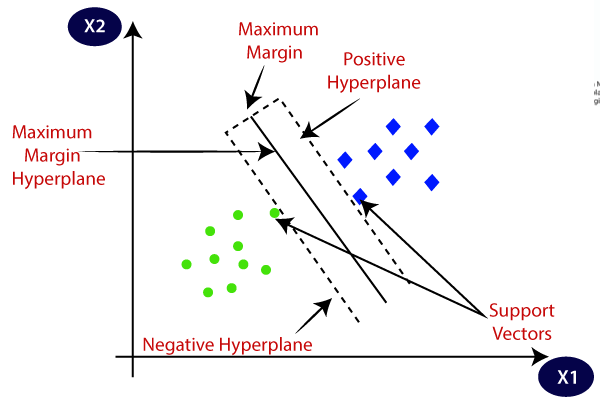

***How Random Forest (RF) Works***

Random Forest grows multiple decision trees which are merged together for a more accurate prediction.

The logic behind the Random Forest model is that multiple uncorrelated models (the individual decision trees) perform much better as a group than they do alone. When using Random Forest for classification, each tree gives a classification or a “vote.” The forest chooses the classification with the majority of the “votes.” When using Random Forest for regression, the forest picks the average of the outputs of all trees.

The key here lies in the fact that there is low (or no) correlation between the individual models—that is, between the decision trees that make up the larger Random Forest model. While individual decision trees may produce errors, the majority of the group will be correct, thus moving the overall outcome in the right direction.

For the RF model, we use all other features asides review text as RF algorithm.

Before proceeding to run the SVM and RF models using the text feature, we must prepare our text data in a suitable format that can be used by the algorithm. This means that we must find a way to represent the text data in a numeric format. The simplest way is to count the number of times each word occurs in the review text and combine the counts of all words to create a numeric representation for each observation. This technique has the disadvantage that commonly occuring words will have large values and could be understood as important features when this is not true. Therefore, we use the preferred option of representing the text using a Term-Frequency Inverse Document Frequency (TF-IDF) vectorization.

In [41]:
tfidf = TfidfVectorizer(ngram_range = (1, 2), stop_words = "english")
x_train_tf = tfidf.fit_transform(x_train)

The TF-IDF vectorization performed in the previous step results in a sparse matrix. The SVM algorithm is preferred when working with text data because it is more suited to work with sparse data compared to other algorithms like Random Forest. They are also better suited to work with input features that are purely numeric, while other algorithms are capable of handling a mixture of numeric and categorical input features. For the text classificatin model, we will use the sklearn.svm.LinearSVC module that is provided by scikit-learn library. SVMs can actually be initialized with different kernel functions, and the linear kernel is recommended for use with text data as there are a large number of features that can be considered linearly separable. It is also faster to fit since it has fewer parameters to optimize.

In the following code, we initialize the model with a certain random_state and specify a tolerance value of 0.00001. The arguments are specific to the type of model we use, and we will show later in this study how we can arrive at the optimal parameter for these arguments. For now we start by specifying some default values and then call the fit method, making sure to use the vectorized independent variables that was created in the previous step:

**Modelling with SVM using review_text only**

In [42]:
model1sv = LinearSVC(random_state = 42, tol = 1e-5)
model1sv.fit(x_train_tf, y_train)

LinearSVC(random_state=42, tol=1e-05)

>*On executing the preceding code, we fit a model using the training data, and the result shows the various parameters of the model that was generated. Most of these are the default values since we specified only the random_state and tolerance.*

**Model evaluation on the training set (SVM)**

In [43]:
y_pred_train_sv1 = model1sv.predict(x_train_tf)
print("Accuracy Score - ", accuracy_score(y_train, y_pred_train_sv1))

Accuracy Score -  1.0


In [44]:
classificationSummary(y_train, y_pred_train_sv1)

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0  918    0
     1    0 3694


**Model evaluation on the test set (SVM)**

In [45]:
x_test_tf = tfidf.transform(x_test)

y_pred_test_sv1 = model1sv.predict(x_test_tf)
print("Accuracy Score - ", accuracy_score(y_test, y_pred_test_sv1))

Accuracy Score -  0.8889852558542931


In [46]:
classificationSummary(y_test, y_pred_test_sv1)

Confusion Matrix (Accuracy 0.8890)

       Prediction
Actual   0   1
     0 133  97
     1  31 892


**Modelling with RF using review_text only**

In [47]:
model1rf = RandomForestClassifier(random_state = 42)
model1rf.fit(x_train_tf, y_train)

RandomForestClassifier(random_state=42)

**Model evaluation on the training set (RF)**

In [48]:
y_pred_train_rf1 = model1rf.predict(x_train_tf)
print("Accuracy Score - ", accuracy_score(y_train, y_pred_train_rf1))

Accuracy Score -  1.0


In [49]:
classificationSummary(y_train, y_pred_train_rf1)

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0  918    0
     1    0 3694


**Model evaluation on the test set (RF)**

In [50]:
x_test_tf = tfidf.transform(x_test)

y_pred_test_rf1 = model1rf.predict(x_test_tf)
print("Accuracy Score - ", accuracy_score(y_test, y_pred_test_rf1))

Accuracy Score -  0.8421509106678231


In [51]:
classificationSummary(y_test, y_pred_test_rf1)

Confusion Matrix (Accuracy 0.8422)

       Prediction
Actual   0   1
     0  58 172
     1  10 913


>*In terms of accuracy, we can conclude that the SVM model has a better peformance on the test set than the RF when review_text only is used for modelling. This result further validates the fact that SVM typically performs better than Random Forest on text data due to its ability to effectively handle high-dimensional feature spaces and capture complex relationships between text features.*

>*The simplest way to validate the text classification model is accuracy: the
ratio of the number of predictions that the model got right to the total number of observations. This can be expressed mathematically as follows:*<br>

>*Accuracy = Number of correction predictions/Total number of predictions made.*

>*To measure the accuracy of the model, we use the trained model to generate predictions and compare with the real values. To generate the predictions, we must apply the same vectorization to the test split of the independent variable and then call the predict method of the trained model. The accuracy_score method is used automatically to generate the accuracy metric by comparing the true values and the model predictions of the test split.*

>*As seen above, a high accuracy score of 100% has been achieved on the training set of both models and 88.90% on the test set for SVM and 84.22% for RF, which indicates that the model is able to predict the recommendations accurately.*

>*Another aspect that we must dig deeper to investigate is how well the model is performing for the different recommendations. Is it better at predicting recommendation (1) or no recommendation (0). To analyse this, another evaluation tool known as the confusion matrix is used. The confusion matrix is a grid that compares the predicted values with the actual values for all the classified observations. The most common representation of a confusion matrix is for a binary classification (just like we have for this study) with only two labels.*




**Separating the data into dependent and independent features, splitting the data into train and test features**

In [52]:
X_r = df_a.drop(columns = {'review_text', 'recommend_index'}) # Independent variable
y_r = df_a["recommend_index"]  # Dependent(target) Variable

In [53]:
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size = 0.2, random_state = 42, stratify = y)

print('size of training data ', x_train_r.shape[0])
print('size of test data ', x_test_r.shape[0])

size of training data  4612
size of test data  1153


**Modelling with Random Forest using age, alike_feedback_count, rating and departname name only**

In [54]:
# fitting the Random Forest Classifier model
model2rf = RandomForestClassifier(random_state = 42)
model2rf.fit(x_train_r, y_train_r)

RandomForestClassifier(random_state=42)

**Model evaluation on the training set (RF Model)**

In [55]:
y_pred_train_rf2 = model2rf.predict(x_train_r)
print("Accuracy Score - ", accuracy_score(y_train_r, y_pred_train_rf2))

Accuracy Score -  0.9603209019947961


>*The RF model has an accuracy of 96.03% on the training set.*

In [56]:
classificationSummary(y_train_r, y_pred_train_rf2)

Confusion Matrix (Accuracy 0.9603)

       Prediction
Actual    0    1
     0  824   94
     1   89 3605


**Model evaluation on the test set (RF Model)**

In [57]:
y_pred_test_rf2 = model2rf.predict(x_test_r)
print("Accuracy Score - ", accuracy_score(y_test_r, y_pred_test_rf2))

Accuracy Score -  0.9080659150043365


>*The RF model has an accuracy score of 90.81% on the test set.*

In [58]:
classificationSummary(y_test_r, y_pred_test_rf2)

Confusion Matrix (Accuracy 0.9081)

       Prediction
Actual   0   1
     0 178  52
     1  54 869


*Using categorical and numerical variables alone, the RF model also has a strong capability of making predictions of the recommendation index with an accuracy of 90.81% on the test set.*

**Modelling with SVM using age, alike_feedback_count, rating and departname name only**

In [59]:
# fitting the support vector model
model2sv = LinearSVC(random_state = 42, tol = 1e-5)
model2sv.fit(x_train_r, y_train_r)

LinearSVC(random_state=42, tol=1e-05)

In [60]:
y_pred_train_sv2 = model2sv.predict(x_train_r)
print("Accuracy Score - ", accuracy_score(y_train_r, y_pred_train_sv2))

Accuracy Score -  0.9327840416305291


>*The SVM model has an accuracy of 93.27% on the training set.*

In [61]:
classificationSummary(y_train_r, y_pred_train_sv2)

Confusion Matrix (Accuracy 0.9328)

       Prediction
Actual    0    1
     0  876   42
     1  268 3426


**Model evaluation on the test set (SVM Model)**

In [62]:
y_pred_test_sv2 = model2sv.predict(x_test_r)
print("Accuracy Score - ", accuracy_score(y_test_r, y_pred_test_sv2))

Accuracy Score -  0.9262792714657415


In [63]:
classificationSummary(y_test_r, y_pred_test_sv2)

Confusion Matrix (Accuracy 0.9263)

       Prediction
Actual   0   1
     0 220  10
     1  75 848


>*In terms of accuracy, we can conclude that the SVM model also has a better peformance on the test set than the RF when age, alike_feedback_count, rating and department name are used for modelling.*

>*The figure below is a sample representation of the confusion matrix that predicts only where a product is recommended or not.*

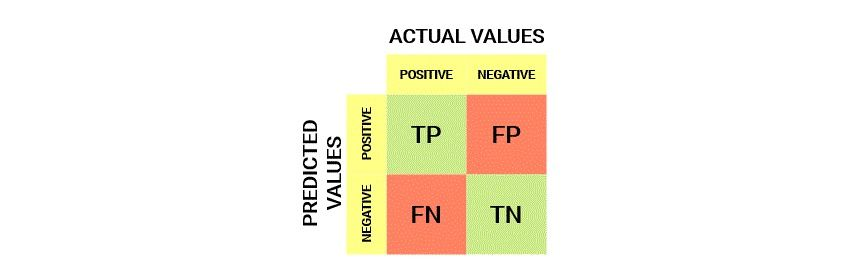

>*The rows depict the predictions, and the columns depict the actual values. Each slot in the matrix is the count of observations falling in that slot:*

>*True Positive: The count of those observation that were predicted to be positive and are indeed positive.*

>*True Negative: The count of those observations that were predicted to be negative and are indeed negative.*

>*False Positive: The count of those observations that were predicted to be positive but are actually negative.*

>*False Negative: The count of those observations that were predicted to be negative but are actually positive*

>*For the training performance of the SVM model using review_text only, the TN is 918, FP is 0, TP is 3,694 and FN is 0. For the test performance, the TN is 133, FP is 97, TP is 892 and FN is 31. For the training performance of the RF model using review_text only, the TN is 918, FP is 0, TP is 3,694 and FN is 0. For the test performance, the TN is 58, FP is 172, TP is 913 and FN is 10.*

>*For the training performance of the RF model using age, alike_feedback_count, department_name and rating, the TN is 824, FP is 94, TP is 3605 and FN is 89. For the test performance, the TN is 178, FP is 52, TP is 869 and FN is 54. For the training performance of the SVM model using age, alike_feedback_count, department_name and rating, the TN is 876, FP is 42, TP is 3426 and FN is 268. For the test performance, the TN is 220, FP is 10, TP is 848 and FN is 75.*



**Precision and Recall**

The real value of using the confusion matrix is in other measures like precision and recall, which gives more insight into how the model performs for different classes.

Precision = True Positive/(True Positive + False Positive)

The precision metric tells us what proportion of predicted positives is actually positive, or how accurate the model is at predicting the positive class. If we want to be sure of our positive predictions, then this a metric that has to be maximized. For example, if we are classifying emails as spam (positive), then we must be accurate at this; otherwise, a good email might accidentally be sent to the spam folder.

Another metric that is derived from the confusion matrix is Recall:

Recall = True Positive/(True Positive + False Negative)

This metric tells us what proportion of real positive value is actually defined by the model. A high recall means that the model is able to capture most of the positive classifications in reality. This is especially important when the cost of not identifying a positive case is very high, for example, if a patient has cancer but a model does not identify it.

From the previous discussion, we can conclude that both precision and recall are important metrics depending on the application of the model. The f1 score is a metric that creates a harmonic mean of both of these measures and can also be used as a proxy to evaluate the overall accuracy of the model:

F1 Score = 2 * (Precision * Recall)/ (Precision + Recall)

An easier way to determine these measures directly is to use the classification_report function from scikit-learn that automatically calculates these values:


**Classification report for models using review_text**

In [64]:
# classification report for the training set (SVM model - review_text)
print(classification_report(y_train, y_pred_train_sv1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       918
           1       1.00      1.00      1.00      3694

    accuracy                           1.00      4612
   macro avg       1.00      1.00      1.00      4612
weighted avg       1.00      1.00      1.00      4612



In [65]:
# classification report for the test set (SVM Model - review_text)
print(classification_report(y_test, y_pred_test_sv1))

              precision    recall  f1-score   support

           0       0.81      0.58      0.68       230
           1       0.90      0.97      0.93       923

    accuracy                           0.89      1153
   macro avg       0.86      0.77      0.80      1153
weighted avg       0.88      0.89      0.88      1153



In [66]:
# classification report for the training set (RF model - review_text)
print(classification_report(y_train, y_pred_train_rf1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       918
           1       1.00      1.00      1.00      3694

    accuracy                           1.00      4612
   macro avg       1.00      1.00      1.00      4612
weighted avg       1.00      1.00      1.00      4612



In [67]:
# classification report for the test set (RF model - review_text)
print(classification_report(y_test, y_pred_test_rf1))

              precision    recall  f1-score   support

           0       0.85      0.25      0.39       230
           1       0.84      0.99      0.91       923

    accuracy                           0.84      1153
   macro avg       0.85      0.62      0.65      1153
weighted avg       0.84      0.84      0.81      1153



**Classification report for models using age, alike_feedback_count, rating and department_name**

In [68]:
# classification report for the training set (RF model - age, alike_feedback_count, rating and department_name)
print(classification_report(y_train_r, y_pred_train_rf2))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       918
           1       0.97      0.98      0.98      3694

    accuracy                           0.96      4612
   macro avg       0.94      0.94      0.94      4612
weighted avg       0.96      0.96      0.96      4612



In [69]:
# classification report for the test set (RF Model - age, alike_feedback_count, rating and department_name)
print(classification_report(y_test_r, y_pred_test_rf2))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       230
           1       0.94      0.94      0.94       923

    accuracy                           0.91      1153
   macro avg       0.86      0.86      0.86      1153
weighted avg       0.91      0.91      0.91      1153



In [70]:
# classification report for the training set (SVM model - age, alike_feedback_count, rating and department_name)
print(classification_report(y_train_r, y_pred_train_sv2))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       918
           1       0.99      0.93      0.96      3694

    accuracy                           0.93      4612
   macro avg       0.88      0.94      0.90      4612
weighted avg       0.94      0.93      0.94      4612



In [71]:
# classification report for the test set (SVM model - age, alike_feedback_count, rating and department_name)
print(classification_report(y_test_r, y_pred_test_sv2))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       230
           1       0.99      0.92      0.95       923

    accuracy                           0.93      1153
   macro avg       0.87      0.94      0.90      1153
weighted avg       0.94      0.93      0.93      1153



>*On the training set of the first set of models, one issue becomes obvious, the model overfits as both the recall and precision values are high. On the test set, the recall and precision values are not as high as what is obtained on the training set of the models that used review_text. The performance of the SVM model in this instance is more reliable considering the classification report which gives 0.68 f1 score for "no recommendation" and 0.93 f1 score for "yes recommendation" as against the RF model which give an f1 score of 0.39 for "no recommendation" and 0.91 for "yes recommendation". This shows the SVM model is more capable of giving a stable and reliable result on data it hasn't seen before when modelling with review_text predictor variable alone.*

>*On the training set of the second set of models, there is less overfitting on the training set of the RF and SVM models. The performance on the test sets are way better than what was obtained in the models built with only the review_text explanatory variable. The RF model gives 0.77 and 0.94 f1 scores for "no recommendation" and "yes recommendation" respectively while the SVM gives 0.84 and 0.95 f1 scores for "no recommendation" and "yes recommendation" respectivley.*

>*Overall, the best model to use is the SVM model that utilizes the age, alike_feedback_countt, department_name and rating explanatory variables. This model gives an accuracy score of 92.63% as against the initial one with 88.90% accuracy.*

It is important that during model evaluation we must analyse several metrics and not rely on the accuracy alone. The reason for a model to overfit is usually due to the class imbalance in the target (recommendation) class which makes up 80.76% of the recommend label and 19.24% of the do not recommend label. This means that when the model is trained, it able to learn the characteristics of the recommmend (Yes - 1) class alone. This problem will be addressed by using a downsampling method.

In [72]:
df_a["recommend_index"].value_counts()

1    4617
0    1148
Name: recommend_index, dtype: int64

**Class Imbalance**

There are several techniques that can be used to overcome the issue of class imbalance. They belong to two categories of upsampling and downsampling techniques. Upsampling techniques refer to methods used to artificially increase the number of observations of the minority class (No(0) in this case). These techniques can vary from simply adding multiple copies to generating new observations using a method like SMOTE. Downsampling techniques refer to methods that are used to reduce the number of observations of the majority class (Yes (1)) in this study. The Yes class will be randomly downsampled to have a similar number of observations as the other class:

In [73]:
# filter recommendations with Yes and sample 1300 rows from it.
df_sample1 = df_a[df_a["recommend_index"] == 1].sample(n=1300)

# create a separate dataframe containing the No recommendation
df_sample0 = df_a[df_a["recommend_index"] != 1]

# concatenate the two dataframe to create the new balanced recommendations dataset
df_balanced = pd.concat([df_sample1, df_sample0])

#check the status of the class imbalance
df_balanced["recommend_index"].value_counts()

1    1300
0    1148
Name: recommend_index, dtype: int64

>*Please note that in performing the downsampling, we are losing information, and this is not generally a good idea. However, when we come across a class imbalance problem, this prevents our model from learning the right information. We try to overcome this by using upsampling and downsampling techniques, but this will always involve a compromise with regard to data quality.*

**Remodelling with the Balanced DataFrame (SVM2)**

In [74]:
# Remove the "review_text" and "recommend_index" columns from the balanced dataframe
X_b = df_balanced.drop(columns = {'review_text', 'recommend_index'}) # Independent variable
y_b = df_balanced["recommend_index"]

# Split the data into training and test sets using 80-20
x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state = 42, stratify=y_b)

# Print the sizes of the training and test sets
print('size of training data ', x_train_b.shape[0])
print('size of test data ', x_test_b.shape[0])

# Create a LinearSVC model with random state of 42 and tolerance of 1e-5
model_b = LinearSVC(random_state=42, tol=1e-5)

# Fit the model to the TF-IDF training data and corresponding labels
model_b.fit(x_train_b, y_train_b)


size of training data  1958
size of test data  490


LinearSVC(random_state=42, tol=1e-05)

**Model evaluation on the balanced training set (SVM2)**

In [75]:
# Make predictions on the training data using the trained model
y_pred_train = model_b.predict(x_train_b)

# Calculate the accuracy score by comparing the predicted labels with the actual labels from the training data
accuracy = accuracy_score(y_train_b, y_pred_train)

# Print the accuracy score
print("Accuracy Score -", accuracy)

Accuracy Score - 0.9325842696629213


In [76]:
classificationSummary(y_train_b, y_pred_train)

Confusion Matrix (Accuracy 0.9326)

       Prediction
Actual   0   1
     0 876  42
     1  90 950


The models give an accuracy of 93.26%% on the training set of the balanced dataset.

**Model evaluation on the balanced test set (SVM2)**

In [77]:
# Make predictions on the test data using the trained model
y_pred_test = model_b.predict(x_test_b)

# Calculate the accuracy score by comparing the predicted labels with the actual labels from the test data
accuracy = accuracy_score(y_test_b, y_pred_test)

# Print the accuracy score
print("Accuracy Score -", accuracy)

Accuracy Score - 0.9469387755102041


In [78]:
classificationSummary(y_test_b, y_pred_test)

Confusion Matrix (Accuracy 0.9469)

       Prediction
Actual   0   1
     0 220  10
     1  16 244


An accuracy of 94.69% was obtained on the test set of the balanced dataset.

**Generating the Precision, Recall and F1 Score for the balanced dataset (SVM2)**

In [79]:
# classification report for the training set
print(classification_report(y_train_b, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       918
           1       0.96      0.91      0.94      1040

    accuracy                           0.93      1958
   macro avg       0.93      0.93      0.93      1958
weighted avg       0.93      0.93      0.93      1958



>*Considering other metrics like precision, recall and f1-score, we can see that the model has a performance of 0.93 and 0.94 f1 score for the No and yes recommendations respectively.*

In [80]:
# classification report for the test set
print(classification_report(y_test_b, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       230
           1       0.96      0.94      0.95       260

    accuracy                           0.95       490
   macro avg       0.95      0.95      0.95       490
weighted avg       0.95      0.95      0.95       490



>*The performance of the model on the test set for predicting No recommendation improved as an f1-score of 0.94 was obtained and for the Yes recommendation, an f1-score of 0.95 was obtained. The performance of this model is stable and can be applied in a real world scenario. We will apply hyperparameter optimization to see if the f1-score can be improved.*

**Using Cross-Validation to Estimate Realistic Accuracy Metrics of the SVM2 model**

For the balanced dataset, we created a train-test split so that we can accurately evaluate our model. Based on the test split on the balanced data, we got an accuracy of 94.69 on the test set%. Some of the techniques that we could use include additional text cleaning steps, choosing different model parameters, and then checking performance on the test split. Our result is always based on a single hold-out dataset that we created using the train-test split. If we go back and change the `random_state` or shuffle our data, then we might get a different test split, which might have different accuracy for the same model. Therefore, we rely heavily on a given test split to determine the accuracy of our model.

*Cross validation* is a technique that allows us to train on different splits of data and validate also on different splits of data in a repetitive manner so that the final model that is trained achieves the right balance between *underfitting* and *overfitting*. Underfitting is the phenomenon where our trained model does not learn the underlying relationship well and makes similar predictions for every observation that are far away from the real value. This is because the chosen model is not complex enough to model the phenomenon (wrong choice of model) or there are insufficient observations from which to learn the relationship. Overfitting is the phenomenon where the chosen model is complex and has fit the underlying pattern very well during training but produces significant deviations on the test data. This indicates that the trained model does not generalize well to unseen data. By using cross validation technique, we become aware of these drawbacks by training and testing on multiple splits of the data and can arrive at a more realistic performance of our model.

To perform cross-validation, we will use the cross_val_score method from scikit-learn. This takes as arguments the model that needs to be fit, the training dataset, and the number of folds that we want to use. In this case, we use a five-fold cross validation strategy and, depending on the number of training observations and availability of computing infrastructure, this can vary between 5 and 10.

In [81]:
# Cross Validation with 5 folds
scores = cross_val_score(estimator = model_b,

                         X = df_balanced[["age", "alike_feedback_count",
                                          "department_name_dresses", "department_name_intimate",
                                          "department_name_jackets", "department_name_tops",
                                          "department_name_trend", "rating_2", "rating_3", "rating_4",
                                          "rating_5"]],

                         y = df_balanced["recommend_index"],
                         cv = 5)

print("Validation scores from each iteration of the cross validation ", scores)
print("Mean value of validation scores ", scores.mean())
print("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.93877551 0.91632653 0.94285714 0.9591002  0.91820041]
Mean value of validation scores  0.9350519594340805
Standard deviation of validation scores  0.01604817899930506


>*From the result, we can see that the validation score varies from 91.63% to 95.9%*. This indicates that the model has a stable performance as reported earlier on the test dataset.  A more realistic accuracy that we can expect from this model is actually the average score of 93.51% derived from cross-validation. It's important to perform this exercise to understand the true potential of any model.

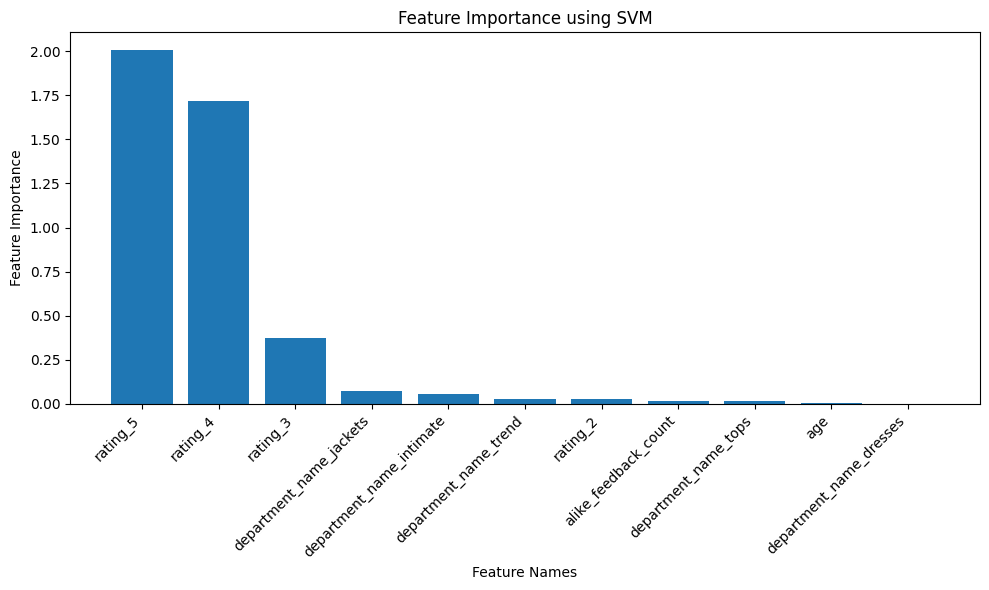

In [82]:
# Get the SVM model coefficients (weights)
feature_importance = np.abs(model_b.coef_[0])

# Get the feature names (assuming they are stored in a list named 'feature_names')
feature_names = ["age", "alike_feedback_count", "department_name_dresses", "department_name_intimate",
                 "department_name_jackets", "department_name_tops", "department_name_trend", "rating_2",
                 "rating_3", "rating_4","rating_5"]

# Sort the features based on their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), sorted_feature_importance)
plt.xticks(range(len(feature_importance)), sorted_feature_names, rotation=45, ha='right')
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Feature Importance using SVM')
plt.tight_layout()
plt.show()


>*The chart above shows that the most important feature that determines whether a product is recommended is rating_5 i.e products with a rating of 5 are mostly recommended for purchase by customers who have previously bought them. Age and department_name_dresses are the least predictors in determining if a product will be recommended or not.*